In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from scipy import signal
from scipy.signal import butter, lfilter, spectrogram
from scipy.io import wavfile
import IPython.display

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


import data

In [2]:
# Read the wav file (mono)
samplingFrequency, signalData = wavfile.read('../data/165_s_22.wav')

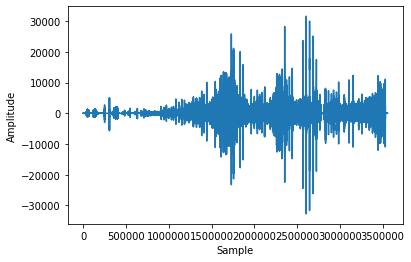

In [3]:
plt.plot(signalData)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

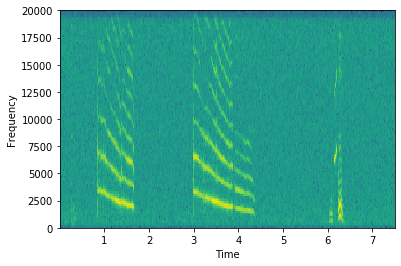

In [4]:
Pxx, freqs, bins, im = plt.specgram(signalData[0:300000],Fs=samplingFrequency) # ~10% of the data
# change bins to 16 instead of 2
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

memmap input:training data

In [5]:
'''
Instead of images and labels, I have spectrogram segments x and y.
So x is input and y would be output (aka labels). 
You train on bunch of (x - power,y - number of samples), let's call it train_x and train_y.
Then when you input test_x, you should get test_y (or vis_x and vis_y in this case)
'''

# spect_height = number of freq. bins
# y always has one time bin
# n_lags is number of time bins of x
# shape of x = (n_lags,spect_height) x number of samples
# shape of y = (1, spect_height) x number of samples

n_lags = 2
spect_height = 32
NIN = n_lags*spect_height

# args for the following class, MemmapHandler
datafolder = '/home/AD/kachiem/memmap/memmap_dataset_stimulus/'
visfolder = '/home/AD/kachiem/memmap/memmap_dataset_stimulus_vis/'
n_lags = 2
spect_height = 32
#subset = 'train'

In [6]:
# loading train data
why = np.lib.format.open_memmap('../data/npy_data/x.npy', dtype='float32', mode='r')
num_data_samples = int(len(why) / spect_height)
xdata = np.lib.format.open_memmap('../data/npy_data/x_data.npy', dtype='float32', mode='r', shape=(n_lags*spect_height, num_data_samples))
ydata = np.lib.format.open_memmap('../data/npy_data/y_data.npy', dtype='float32', mode='r', shape=(spect_height, num_data_samples))

why.shape, xdata.shape, ydata.shape

((9597568,), (64, 149962), (32, 149962))

memmap input: test data

In [7]:
# loading test data
why_vis = np.lib.format.open_memmap('../data/npy_data/y_vis.npy', dtype='float32', mode='r')
num_data_samples_vis = int(len(why_vis) / spect_height)
xdata_vis = np.lib.format.open_memmap('../data/npy_data/x_data_vis.npy', dtype='float32', mode='r', shape=(n_lags*spect_height, num_data_samples_vis))
ydata_vis = np.lib.format.open_memmap('../data/npy_data/y_data_vis.npy', dtype='float32', mode='r', shape=(spect_height, num_data_samples_vis))

why_vis.shape, xdata_vis.shape, ydata_vis.shape

((32, 16653), (64, 16653), (32, 16653))

In [20]:
xdata.T.shape

(149962, 64)

memmap to array: training + test

In [8]:
# convert to array
def memmap_to_arr(memmap, shape):
    # memmap: input np.memmap()
    # shape: (samples, channels, features (freq))
    
    memmap = np.asarray(memmap.T[:].tolist()).reshape(shape)
    lst = [np.asarray(memmap[i]) for i in range(0,len(memmap))]
    arr = np.array(lst)
    print(arr.shape)
    
    return arr

In [9]:
# test 
data_vis = why_vis[:]
x_data_vis = memmap_to_arr(xdata_vis, (xdata_vis.shape[1], 2, 32))
y_data_vis = memmap_to_arr(ydata_vis, (ydata_vis.shape[1], 1, 32))
num_data_samples_vis = int(len(data_vis)/ spect_height)

print(type(x_data_vis))
data_vis.shape, x_data_vis.T.shape

(16653, 2, 32)
(16653, 1, 32)
<class 'numpy.ndarray'>


((32, 16653), (32, 2, 16653))

In [22]:
# train
data = why[:]
x_data = memmap_to_arr(xdata, (xdata.shape[1], 16, 32))
y_data = memmap_to_arr(ydata, (ydata.shape[1], 1, 32))

#data.shape

### subsetting to match vis data
n_vis = int(x_data_vis.shape[0])
data = why[:n_vis]
x_data = x_data[:n_vis, :, :]
y_data = y_data[:n_vis, :, :]

num_data_samples = int(len(data) / spect_height)

print(type(x_data))
data.shape, x_data.shape, y_data.shape

ValueError: cannot reshape array of size 9597568 into shape (149962,16,32)

In [11]:
# placing data into tuple objects
all_data = (data, x_data, y_data, data_vis, x_data_vis, y_data_vis)
train_data = (data, x_data, y_data)
test_data = (data_vis, x_data_vis, y_data_vis)

vae_cnn

In [12]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [13]:
def plot_results(models,
                 data,
                 batch_size=64,
                 model_name="vae_cnn_birdsong"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# loading memmap dataset
#(x_train, y_train), (x_test, y_test) = (all_data[1], all_data[2]), (all_data[4], all_data[5])
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("loading data:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

slice_size = x_train.shape[2]
#x_train = np.reshape(x_train, [-1, slice_size, slice_size, 1])
#x_test = np.reshape(x_test, [-1, slice_size, slice_size, 1])
image_size = x_train.shape[1]
# 60000, 28, 28
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 64
kernel_size = 3
filters = 8 # bc batch size 128->64 (was16)
latent_dim = 2
epochs = 10 # for shorter runtime

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')


loading data: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 16)   160         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 32)     4640        conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1568)         0           conv2d_

In [14]:
np.shape(all_data)

(6,)

In [15]:

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load h5 model trained weights"
    parser.add_argument("-w", "--weights", help=help_)
    help_ = "Use mse loss instead of binary cross entropy (default)"
    parser.add_argument("-m", "--mse", help=help_, action='store_true')
    args = parser.parse_args()
    models = (encoder, decoder)
    data = (test_data[1], test_data[2])

    # VAE loss = mse_loss or xent_loss + kl_loss
    if args.mse:
        reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
    else:
        reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                  K.flatten(outputs))

    reconstruction_loss *= image_size * image_size
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    vae.summary()
    plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

    if args.weights:
        vae.load_weights(args.weights)
    else:
        # train the autoencoder
        vae.fit(all_data[1],
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(all_data[4], None))
        vae.save_weights('vae_cnn_mnist.h5')
    plot_results(models, data, batch_size=batch_size, model_name="vae_cnn_song")

usage: ipykernel_launcher.py [-h] [-w WEIGHTS] [-m]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/kachiem/.local/share/jupyter/runtime/kernel-37588ba3-5cc9-497e-85cf-96f662b9d775.json


SystemExit: 2

/home/AD/kachiem/miniconda3/envs/tf-conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
